# Chapter 12-05
## Pythonと機械学習

### 機械学習による数値の予測

In [1]:
# 予測に利用するデータを作る
import numpy as np

#乱数のシードを設定
np.random.seed(9)
# 0から1まで100個の数値を生成，乱数要素を混ぜる前のx
x_orig = np.linspace(0, 1, 100)

def f(x):
    # xに対応するsinを返す関数
    return np.sin(2 * np.pi * x)

# 0から1まで100個のばらけたサンプルデータ(x)を生成
x = np.random.uniform(0, 1, size=100)[:, np.newaxis]
# xに対応するsinに乱数値を足してサンプルデータ(y)を生成
y = f(x)+np.random.normal(scale=0.3, size=100)[:, np.newaxis]

/Users/takuya.teramoto/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(0, 1)

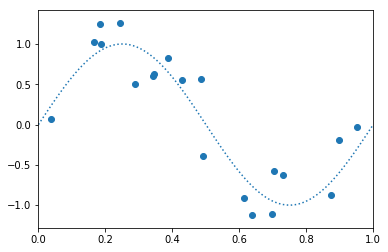

In [2]:
# データをグラフに描く
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
# 学習用データとテスト用データに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

# 元のsinとサンプルデータをplot
plt.plot(x_orig, f(x_orig), ls=':')
plt.scatter(x_train, y_train)
plt.xlim((0, 1))

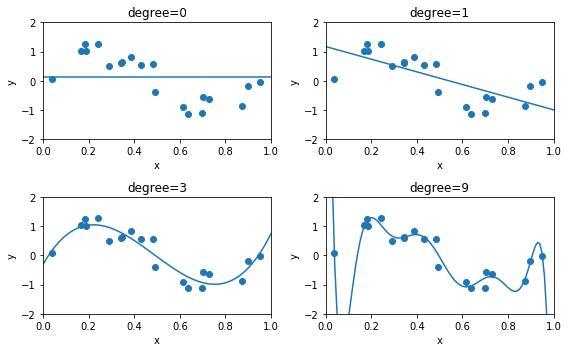

In [3]:
# 最小二乗法の多項式近似を使ってデータを学習する
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 2x2のグラフを描く準備をする
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# 次数0, 1, 3, 9について学習した結果を表示
for ax, deg in zip(axs.ravel(), [0, 1, 3, 9]):
    # パイプラインを作る
    e = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    # 学習セットで学習をする
    e.fit(x_train, y_train)
    # 元のxを与えて予測
    px = e.predict(x_orig[:, np.newaxis])
    # 予測結果のグラフとテストデータの点を描画
    ax.scatter(x_train, y_train)
    ax.plot(x_orig, px)
    ax.set(xlim=(0, 1), ylim=(-2, 2),
           ylabel='y', xlabel='x',
           title='degree={}'.format(deg))

plt.tight_layout()

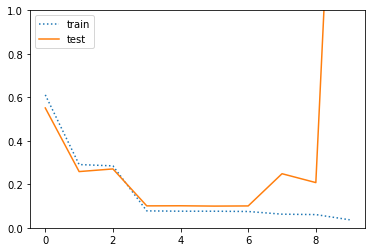

In [4]:
# テストデータを使って過学習の様子をグラフ化する
from sklearn.metrics import mean_squared_error

# 実データとの誤差を保存するarray
train_error = np.empty(10)
test_error = np.empty(10)
# 次数0から9について調べる
for deg in range(10):
    # モデルを作る
    e = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    e.fit(x_train, y_train)
    # テストデータを使って，予測値と実際の値の誤差を調べる
    train_error[deg] = mean_squared_error(y_train, e.predict(x_train))
    test_error[deg] = mean_squared_error(y_test, e.predict(x_test))

# グラフを描く
plt.plot(np.arange(10), train_error, ls=':', label='train')
plt.plot(np.arange(10), test_error, ls='-', label='test')
plt.ylim((0, 1))
plt.legend(loc='upper left')

### 名前から性別を判定する

In [5]:
# データを読み込み整形する
import numpy as np
from sklearn.cross_validation import train_test_split

np.random.seed(9)
# 男女のタグ付きひらがなの名前データを読み込む
txtbody = open('names.txt', encoding='utf-8')
# NumPyのarrayに変換
jnames = np.array([x.split() for x in txtbody], dtype='U12')
# 名前と性別に分割
names_train, gender_train, = jnames[:, 1], jnames[:, 0]

In [6]:
# ひらがなの読みを2文字ごとに分割する関数を作る
def split_in_2words(name):
    # 名前を2文字ごとに分割する関数
    return [name[i:i+2] for i in range(len(name)-1)]

In [7]:
# 関数を呼び出してみる
split_in_2words("とものり")

['とも', 'もの', 'のり']

In [8]:
# 学習データを作ってベクトル化の前段階となるデータを作る
from sklearn.feature_extraction.text import CountVectorizer
bow_t = CountVectorizer(analyzer=split_in_2words).fit(names_train)

In [9]:
name = 'かんかん'
b1 = bow_t.transform([name])
print(b1[0])

  (0, 283)	2
  (0, 1898)	1


In [10]:
# 出力データから文字列を逆引きする
# (注)直前の出力セルに表示されたIDに置き換えてください
print(bow_t.get_feature_names()[283])
print(bow_t.get_feature_names()[1898])

かん
んか


In [11]:
# 学習データを使って文字列の出現数を数える
names_bow = bow_t.transform(names_train)

In [12]:
# TF-IDFでデータの重み付けと正規化を行う
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_t = TfidfTransformer().fit(names_bow)

In [13]:
# tfidf_tでどのような変換が行われるか確認する
tfidf1 = tfidf_t.transform(b1)
print(tfidf1)

  (0, 1898)	0.530554460022041
  (0, 283)	0.8476508508523546


In [14]:
# ナイーブベイズの多項モデルを使った学習器を作る
from sklearn.naive_bayes import MultinomialNB
# 文字列の重み付けと正規化を行う
names_tfidf = tfidf_t.transform(names_bow)
# 学習を実行
namegender_detector = MultinomialNB().fit(names_tfidf, gender_train)

In [15]:
# 「かんかん」という名前の性別を予測する
print(namegender_detector.predict(tfidf1)[0])

boy


In [16]:
# 文字列を与えて性別を予測する関数を定義
def predict_gender(name):
    # 性別を予測する
    bow = bow_t.transform([name])
    n_tfidf = tfidf_t.transform(bow)
    return namegender_detector.predict(n_tfidf)[0]

In [17]:
print(predict_gender("のんな"))

girl


In [18]:
# データを学習データとテストデータに分割
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_in_2words)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [19]:
# パイプラインを使って学習とテストを行う
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         names_train,  # training data
                         gender_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[0.78397213 0.80836237 0.78571429 0.81326353 0.79057592 0.7556719
 0.78708551 0.77661431 0.78708551 0.8006993 ]
